<a href="https://colab.research.google.com/github/ggmeiner22/Camera-Calibration-with-Gradio-UI/blob/main/Camera_Calibration_with_Gradio_UI2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Camera Calibration (OpenCV + Gradio UI)
## In this project, I will calibrate my own camera using OpenCV’s calibration tools.

### The goal is to compute my camera’s intrinsic parameters (focal length, principal point, distortion coefficients).

### I will also build a small Gradio user interface (UI) to streamline the calibration process, visualize results, and demonstrate understanding of camera geometry.



In [62]:
%pip -q install opencv-python-headless numpy gradio plotly pytransform3d==3.3.0

Add imports:

In [63]:
import os, json, glob, io, base64, math, textwrap, random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

import numpy as np
import cv2 as cv
import gradio as gr
import plotly.graph_objects as go
from pytransform3d.transformations import plot_transform

# Ensure base dir on Colab
BASE_DIR = "/content"
IMG_DIR  = os.path.join(BASE_DIR, "images")
os.makedirs(IMG_DIR, exist_ok=True)

RNG = np.random.default_rng(42)

1) Collect Calibration Images

Save the image into /content/pattern.png

In [64]:
# Download the OpenCV checkerboard pattern
import urllib.request

url = "https://docs.opencv.org/4.x/pattern.png"
save_path = "/content/pattern.png"

urllib.request.urlretrieve(url, save_path)
print(f"Saved checkerboard to {save_path}")

Saved checkerboard to /content/pattern.png


Print the OpenCV chessboard calibration pattern: pattern.png.

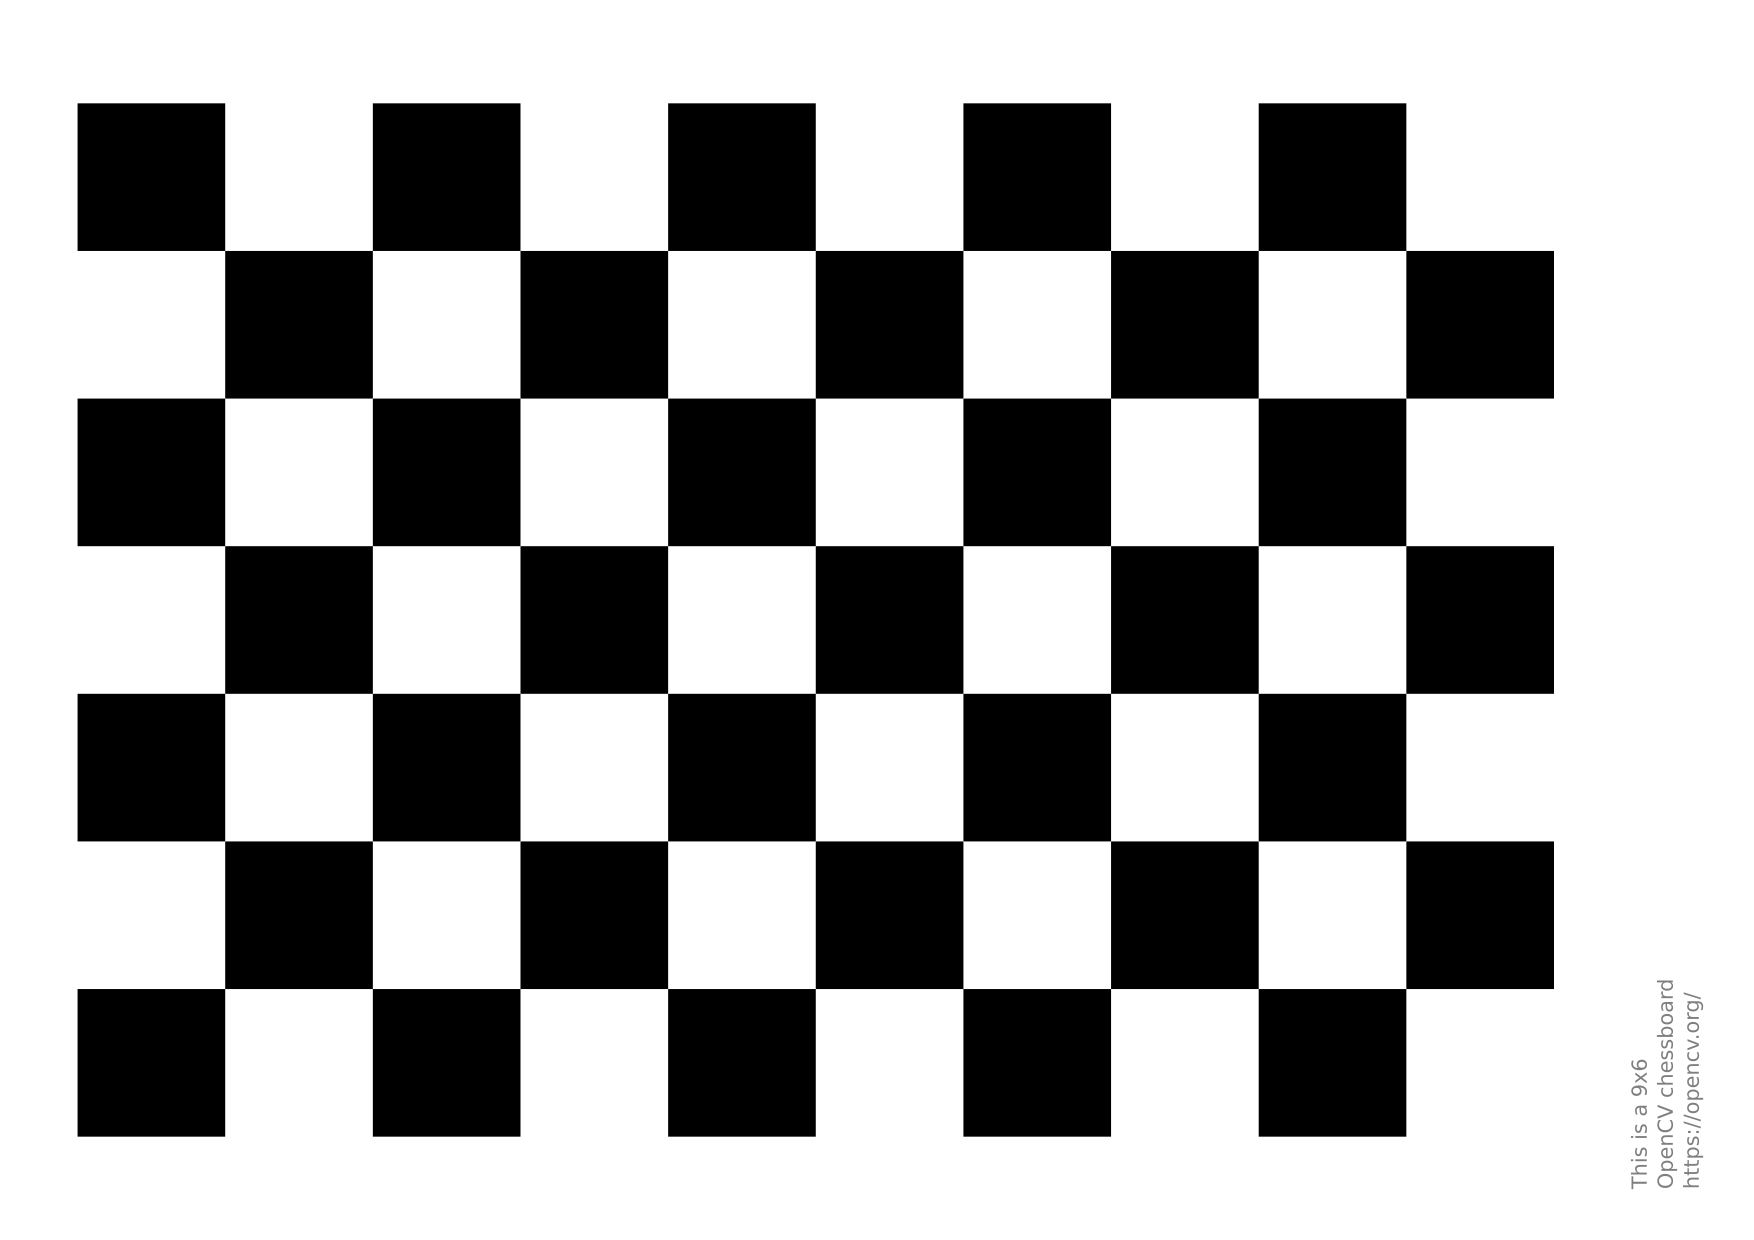

In [65]:
from IPython.display import Image, display
display(Image(filename=save_path))

I/O class

In [66]:
class IO:
    @staticmethod
    def ensure_dir(path: str):
        os.makedirs(path, exist_ok=True)

    @staticmethod
    def list_images(folder: str, exts=(".jpg",".jpeg",".png",".bmp")) -> List[str]:
        files = []
        for e in exts:
            files.extend(glob.glob(os.path.join(folder, f"*{e}")))
        return sorted(files)

    @staticmethod
    def save_json(obj: Dict[str, Any], path: str):
        with open(path, "w") as f:
            json.dump(obj, f, indent=2)

    @staticmethod
    def load_json(path: str) -> Dict[str, Any]:
        with open(path, "r") as f:
            return json.load(f)

    @staticmethod
    def imread_rgb(path: str) -> np.ndarray:
        bgr = cv.imread(path, cv.IMREAD_COLOR)
        if bgr is None:
            raise FileNotFoundError(path)
        return cv.cvtColor(bgr, cv.COLOR_BGR2RGB)

    @staticmethod
    def imwrite_rgb(path: str, rgb: np.ndarray):
        bgr = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)
        cv.imwrite(path, bgr)

Board class

In [67]:
class Board:
    """Chessboard model (pattern_size uses inner corners)."""
    @staticmethod
    def object_points(pattern_size: Tuple[int,int], square_size_m: float) -> np.ndarray:
        cols, rows = pattern_size
        objp = np.zeros((rows*cols, 3), np.float32)
        xs, ys = np.meshgrid(np.arange(cols), np.arange(rows))
        objp[:, :2] = np.vstack([xs.ravel(), ys.ravel()]).T * square_size_m
        return objp

    @staticmethod
    def pattern_tuple(cols: int, rows: int) -> Tuple[int,int]:
        return (cols, rows)

Image class

In [68]:
class Img:
    @staticmethod
    def draw_axes(rgb: np.ndarray, K: np.ndarray, D: np.ndarray, rvec: np.ndarray, tvec: np.ndarray, axis_len: float) -> np.ndarray:
        img = rgb.copy()
        axis_3d = np.float32([
            [0, 0, 0],
            [axis_len, 0, 0],
            [0, axis_len, 0],
            [0, 0, -axis_len]
        ])
        axis_2d, _ = cv.projectPoints(axis_3d, rvec, tvec, K, D)
        axis_2d = axis_2d.reshape(-1, 2).astype(int)
        o, x, y, z = map(tuple, axis_2d)
        cv.line(img, o, x, (255,0,0),   3)  # X red
        cv.line(img, o, y, (0,255,0),   3)  # Y green
        cv.line(img, o, z, (0,0,255),   3)  # Z blue
        return img

    @staticmethod
    def put_text(img: np.ndarray, text: str, org=(10,30)):
        out = img.copy()
        cv.putText(out, text, org, cv.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,0), 2, cv.LINE_AA)
        return out

Camera class

In [69]:
class Cam:
    @staticmethod
    def rodrigues_to_R(rvec: np.ndarray) -> np.ndarray:
        R, _ = cv.Rodrigues(rvec)
        return R

    @staticmethod
    def camera_center_in_board(rvec: np.ndarray, tvec: np.ndarray) -> np.ndarray:
        # X_c = R X_w + t  ->  C_w = -R^T t
        R = Cam.rodrigues_to_R(rvec)
        C = -R.T @ tvec.reshape(3,1)
        return C.flatten()

    @staticmethod
    def to_jsonable(mat: np.ndarray) -> List[List[float]]:
        return mat.tolist()

Calibration class

In [102]:
class Calib:
    @staticmethod
    def detect_corners(image_paths: List[str], pattern_size: Tuple[int,int]):
        objp_unit = Board.object_points(pattern_size, square_size_m=1.0)  # scale later
        objpoints, imgpoints = [], []
        img_size = None

        for p in image_paths:
            bgr = cv.imread(p, cv.IMREAD_COLOR)
            if bgr is None:
                print(f"[WARN] Could not read image: {p}")
                continue
            gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)
            if img_size is None:
                img_size = (gray.shape[1], gray.shape[0])
            ret, corners = cv.findChessboardCorners(gray, pattern_size,
                                                    flags=cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_NORMALIZE_IMAGE)
            if ret:
                corners_ref = cv.cornerSubPix(
                    gray, corners, (11,11), (-1,-1),
                    (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
                )
                objpoints.append(objp_unit.copy())
                imgpoints.append(corners_ref)
            else:
                print(f"[INFO] Chessboard not found: {os.path.basename(p)}")

        return objpoints, imgpoints, img_size

    @staticmethod
    def calibrate(objpoints_unit, imgpoints, img_size, square_size_m: float):
        if img_size is None or len(objpoints_unit) == 0:
            raise ValueError("No valid detections or unknown image size.")
        scaled_objpoints = [op * square_size_m for op in objpoints_unit]

        ret, K, D, rvecs, tvecs = cv.calibrateCamera(
            scaled_objpoints, imgpoints, img_size, None, None, flags=cv.CALIB_RATIONAL_MODEL
        )
        return {
            "rms_reprojection_error": float(ret),
            "K": K, "D": D, "rvecs": rvecs, "tvecs": tvecs, "image_size": img_size
        }

    def undistort_preview(rgb: np.ndarray, K: np.ndarray, D: np.ndarray,
                          calib_size: tuple[int, int] | None = None):
        """
        Input : rgb (HxWx3, RGB, uint8), intrinsics (K), distortion (D),
                optional calibration size (width, height).
        Output: (before_rgb, after_rgb) for UI preview.
        """
        after = undistort_single_after(rgb, K, D, calib_size=calib_size)
        return rgb, after



    @staticmethod
    def save_calibration_json(path: str, calib: Dict[str, Any]):
        out = {
            "rms_reprojection_error": calib["rms_reprojection_error"],
            "K": Cam.to_jsonable(calib["K"]),
            "D": Cam.to_jsonable(calib["D"]),
            "rvecs": [rv.flatten().tolist() for rv in calib["rvecs"]],
            "tvecs": [tv.flatten().tolist() for tv in calib["tvecs"]],
            "image_width": int(calib["image_size"][0]),
            "image_height": int(calib["image_size"][1]),
        }
        IO.save_json(out, path)

    @staticmethod
    def estimate_poses(image_paths, pattern_size, square_size_m, K, D, imgpoints):
        objp = Board.object_points(pattern_size, square_size_m)
        results = []
        for pth, corners in zip(image_paths, imgpoints):
            ok, rvec, tvec = cv.solvePnP(objp, corners, K, D, flags=cv.SOLVEPNP_ITERATIVE)
            if ok:
                results.append((pth, rvec, tvec))
        return results

Pose plot (3D) helper + full pipeline function

In [101]:
def plot_camera_poses_3d(pose_list: List[Tuple[str,np.ndarray,np.ndarray]], square_size_m: float):
    fig = go.Figure()
    if len(pose_list) == 0:
        fig.update_layout(title="No poses to display", scene_aspectmode='data')
        return fig

    centers, labels = [], []
    for pth, rvec, tvec in pose_list:
        C = Cam.camera_center_in_board(rvec, tvec)
        centers.append(C); labels.append(os.path.basename(pth))
    centers = np.array(centers)

    # Board plane grid (Z=0)
    grid_n = 8
    xs = np.linspace(0, grid_n*square_size_m, grid_n+1)
    ys = np.linspace(0, grid_n*square_size_m, grid_n+1)
    for x in xs:
        fig.add_trace(go.Scatter3d(x=[x]*len(ys), y=ys, z=[0]*len(ys), mode="lines", opacity=0.3, name="board grid"))
    for y in ys:
        fig.add_trace(go.Scatter3d(x=xs, y=[y]*len(xs), z=[0]*len(xs), mode="lines", opacity=0.3, showlegend=False))

    # Camera centers
    fig.add_trace(go.Scatter3d(
        x=centers[:,0], y=centers[:,1], z=centers[:,2],
        mode="markers+text", text=[f"#{i}" for i in range(len(labels))], textposition="top center",
        marker=dict(size=4), name="Camera centers"
    ))

    # Board axes at origin
    L = 3.0 * square_size_m
    axes = {"X":[[0,L],[0,0],[0,0]], "Y":[[0,0],[0,L],[0,0]], "Z":[[0,0],[0,0],[0,L]]}
    for name, (ax, ay, az) in axes.items():
        fig.add_trace(go.Scatter3d(x=ax, y=ay, z=az, mode="lines", name=f"{name}-axis"))

    fig.update_layout(
        title="Estimated Camera Poses w.r.t. Chessboard",
        scene=dict(xaxis_title="X (m)", yaxis_title="Y (m)", zaxis_title="Z (m)", aspectmode="data"),
        legend=dict(x=0, y=1.0)
    )
    return fig


def run_full_calibration(
    image_dir: str,
    pattern_cols: int,
    pattern_rows: int,
    square_size_m: float,
    max_overlay_images: int = 8,
    save_json_path: str = os.path.join(BASE_DIR, "calibration.json")
) -> Dict[str, Any]:
    pattern_size = Board.pattern_tuple(pattern_cols, pattern_rows)
    image_paths = IO.list_images(image_dir)
    if len(image_paths) == 0:
        raise RuntimeError(f"No images found in {image_dir}. Upload .jpeg files first.")

    objpoints_unit, imgpoints, img_size = Calib.detect_corners(image_paths, pattern_size)
    if len(imgpoints) < 8:
        raise RuntimeError(f"Not enough valid detections: {len(imgpoints)} found; need ≥ 8.")

    calib = Calib.calibrate(objpoints_unit, imgpoints, img_size, square_size_m)
    Calib.save_calibration_json(save_json_path, calib)

    K, D = calib["K"], calib["D"]
    pose_list = Calib.estimate_poses(image_paths, pattern_size, square_size_m, K, D, imgpoints)

    # Sample overlays
    idxs = list(range(len(pose_list)))
    random.shuffle(idxs)
    idxs = idxs[:max_overlay_images]
    overlay_images = []
    for i in idxs:
        pth, rvec, tvec = pose_list[i]
        rgb = IO.imread_rgb(pth)
        img_axes = Img.draw_axes(rgb, K, D, rvec, tvec, axis_len=3.0*square_size_m)
        overlay_images.append(Img.put_text(img_axes, f"axes: {os.path.basename(pth)}", (10,30)))

    undist_before = undist_after = None
    if len(pose_list) > 0:
        p0, _, _ = pose_list[0]
        img0 = IO.imread_rgb(p0)
        # calib["image_size"] is (w, h) in your pipeline
        undist_before, undist_after = Calib.undistort_preview(
        img0, K, D, calib_size=tuple(calib["image_size"])
        )

    fig = plot_camera_poses_3d(pose_list, square_size_m)

    return {
        "json_path": save_json_path,
        "rms": calib["rms_reprojection_error"],
        "K": calib["K"],
        "D": calib["D"],
        "image_size": calib["image_size"],
        "num_images": len(image_paths),
        "num_used": len(imgpoints),
        "overlay_images": overlay_images,
        "undist_before": undist_before,
        "undist_after": undist_after,
        "pose_fig": fig
    }

Helper to save images to files

In [72]:
# Directory for UI images
EXPORT_DIR = os.path.join(BASE_DIR, "exports")
IO.ensure_dir(EXPORT_DIR)

def _to_file_list(images, prefix="overlay"):
    """
    Save a list of RGB numpy images to PNG files and return their paths.
    """
    paths = []
    for i, img in enumerate(images):
        fp = os.path.join(EXPORT_DIR, f"{prefix}_{i:02d}.png")
        IO.imwrite_rgb(fp, img)  # writes RGB -> PNG
        paths.append(fp)
    return paths


Image saver

In [73]:
from PIL import Image
import uuid, time

EXPORT_ROOT = os.path.join(BASE_DIR, "exports")
IO.ensure_dir(EXPORT_ROOT)

def _save_gallery_images_np(images, prefix="overlay", max_side=1600):
    """
    Accepts a list of RGB uint8 numpy arrays and returns a list of fresh, unique PNG file paths.
    Resizes if images are very large to avoid Colab/Gradio rendering issues.
    """
    # Create a unique “session” folder each run to dodge caching/collisions
    session_dir = os.path.join(EXPORT_ROOT, f"{prefix}_{int(time.time())}_{uuid.uuid4().hex[:6]}")
    IO.ensure_dir(session_dir)

    paths = []
    for i, arr in enumerate(images):
        if arr is None:
            continue
        # Ensure uint8 RGB
        if arr.dtype != np.uint8:
            arr = np.clip(arr, 0, 255).astype(np.uint8)
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)
        if arr.shape[2] == 4:  # RGBA -> RGB
            arr = arr[..., :3]

        im = Image.fromarray(arr, mode="RGB")
        # Downscale large images for more reliable display
        w, h = im.size
        scale = min(1.0, max_side / max(w, h))
        if scale < 1.0:
            im = im.resize((int(w*scale), int(h*scale)), Image.LANCZOS)

        fp = os.path.join(session_dir, f"{prefix}_{i:02d}.png")
        im.save(fp, format="PNG", optimize=True)
        paths.append(fp)
    return paths


Downscale helper

In [74]:
def _downscale_images_np(images, max_side=1200):
    """
    Takes a list of RGB np.uint8 images and returns a list of downscaled images (as np arrays).
    This avoids Colab/Gradio rendering issues with very large images or path caching.
    """
    out = []
    for arr in images:
        if arr is None:
            continue
        im = arr
        if im.dtype != np.uint8:
            im = np.clip(im, 0, 255).astype(np.uint8)
        if im.ndim == 2:
            im = np.stack([im]*3, axis=-1)
        if im.shape[2] == 4:
            im = im[..., :3]

        h, w = im.shape[:2]
        scale = min(1.0, float(max_side) / float(max(h, w)))
        if scale < 1.0:
            nh, nw = int(round(h*scale)), int(round(w*scale))
            im = cv.resize(im, (nw, nh), interpolation=cv.INTER_AREA)
        out.append(im)
    return out


In [75]:
def _to_rgb_uint8(img: np.ndarray) -> np.ndarray:
    """Return a contiguous RGB uint8 HxWx3 image (downscale if huge)."""
    if img is None:
        return None

    arr = img
    # Ensure uint8 range
    if arr.dtype != np.uint8:
        arr = np.clip(arr, 0, 255).astype(np.uint8)

    # Expand gray to RGB
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)

    # Drop alpha if present
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[:, :, :3]

    # Sometimes arrays come in BGR; our pipeline produces RGB, but to be safe:
    # If you KNOW an array is BGR, uncomment:
    # arr = cv.cvtColor(arr, cv.COLOR_BGR2RGB)

    # Downscale very large images for Colab stability
    h, w = arr.shape[:2]
    max_side = 1200
    scale = min(1.0, max_side / float(max(h, w)))
    if scale < 1.0:
        arr = cv.resize(arr, (int(round(w*scale)), int(round(h*scale))), interpolation=cv.INTER_AREA)

    # Make sure memory is contiguous; Gradio can be picky here
    arr = np.ascontiguousarray(arr)
    return arr


def _prep_gallery(images: list) -> list:
    """Prepare a list of images for gr.Gallery(type='numpy')."""
    out = []
    for im in images or []:
        rgb = _to_rgb_uint8(im)
        if rgb is not None:
            out.append(rgb)
    return out


In [87]:
from PIL import Image

def _to_pil_rgb(img_np, max_side=1200):
    if img_np is None or img_np.size == 0:
        return None
    if img_np.ndim < 2:
        return None
    arr = img_np
    if arr.dtype != np.uint8:
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[:, :, :3]
    h, w = arr.shape[:2]
    if h == 0 or w == 0:
        return None
    scale = min(1.0, max_side / float(max(h, w)))
    if scale < 1.0:
        nh, nw = int(round(h*scale)), int(round(w*scale))
        if nh > 0 and nw > 0:
            arr = cv.resize(arr, (nw, nh), interpolation=cv.INTER_AREA)
    return Image.fromarray(arr, mode="RGB")


def _prep_gallery_pil(images_list):
    out = []
    for im in images_list or []:
        pi = _to_pil_rgb(im)
        if pi is not None:          # skip empties
            out.append(pi)
    return out



In [77]:
import base64, io
from PIL import Image

def _pil_to_base64(img: Image.Image) -> str:
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("ascii")

def _imgs_to_html(pils, captions=None, max_w=380):
    if not pils:
        return "<div style='color:#bbb'>No images to display.</div>"
    cards = []
    for i, im in enumerate(pils):
        b64 = _pil_to_base64(im)
        cap = (captions[i] if captions and i < len(captions) else "")
        cards.append(
            f"""
            <div style="display:flex;flex-direction:column;align-items:center;margin:8px;">
              <img src="data:image/png;base64,{b64}" style="max-width:{max_w}px;height:auto;border:1px solid #444;border-radius:6px;" />
              <div style="color:#ccc;font-size:12px;margin-top:4px">{cap}</div>
            </div>
            """
        )
    return f"<div style='display:flex;flex-wrap:wrap;'>{''.join(cards)}</div>"


In [105]:
def undistort_single_after(rgb: np.ndarray, K: np.ndarray, D: np.ndarray,
                           calib_size: tuple[int, int] | None = None) -> np.ndarray:
    """
    Return just the undistorted image (RGB, uint8) for one input frame.

    rgb         : HxWx3, RGB, uint8
    K, D        : intrinsics and distortion from calibration (float64 recommended)
    calib_size  : (calib_width, calib_height) from calibration. If present and the
                  input image size differs, K is scaled accordingly.
    """
    assert rgb.ndim == 3 and rgb.shape[2] == 3, "rgb must be HxWx3 RGB"
    h, w = rgb.shape[:2]

    # Ensure expected types/shapes for OpenCV
    K = np.asarray(K, dtype=np.float64).copy()
    D = np.asarray(D, dtype=np.float64).reshape(-1)

    # If current image size != calibration size, scale K
    if calib_size is not None:
        cw, ch = calib_size  # width, height from calibration
        if (w, h) != (cw, ch):
            sx, sy = w / float(cw), h / float(ch)
            K[0, 0] *= sx       # fx
            K[0, 2] *= sx       # cx
            K[1, 1] *= sy       # fy
            K[1, 2] *= sy       # cy

    # Build rectification map and remap (more stable than single-call undistort)
    newK, _ = cv.getOptimalNewCameraMatrix(
        K, D, (w, h), alpha=0.5, centerPrincipalPoint=True
    )
    map1, map2 = cv.initUndistortRectifyMap(K, D, None, newK, (w, h), cv.CV_16SC2)

    bgr_in  = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)
    bgr_out = cv.remap(bgr_in, map1, map2, interpolation=cv.INTER_LINEAR,
                       borderMode=cv.BORDER_CONSTANT)
    return cv.cvtColor(bgr_out, cv.COLOR_BGR2RGB)


Run once without the UI (quick test)

In [78]:
# Example (set these to your print & board):
pattern_cols = 9              # inner corners across
pattern_rows = 6              # inner corners down
square_size_m = 0.0217714286  # 6/7 inch in meters (~21.771 mm)

res = run_full_calibration(IMG_DIR, pattern_cols, pattern_rows, square_size_m, max_overlay_images=6)
print(f"RMS: {res['rms']:.4f}, saved: {res['json_path']}")
res['pose_fig'].show()


RMS: 0.4615, saved: /content/calibration.json


Build a Gradio Inline UI

In [103]:
STATE = {
    "image_dir": IMG_DIR,
    "last_calib_json": os.path.join(BASE_DIR, "calibration.json")
}

def ui_save_uploads(files):
    IO.ensure_dir(STATE["image_dir"])
    saved = 0
    paths = []
    if not files:
        return "No files uploaded.", []
    for f in files:
        fname = os.path.basename(f.name)
        dst = os.path.join(STATE["image_dir"], fname)
        with open(f.name, "rb") as src, open(dst, "wb") as out:
            out.write(src.read())
        saved += 1
        paths.append(dst)
    return f"Saved {saved} image(s) to {STATE['image_dir']}", IO.list_images(STATE["image_dir"])

def ui_run_calibration(pattern_cols, pattern_rows, square_size_m, max_overlay):
    """
    Run calibration and prepare UI outputs (images rendered as HTML).
    Returns:
      info_markdown, pose_fig (plotly.Figure), overlay_html (str), undist_html (str)
    """
    try:
        result = run_full_calibration(
            image_dir=STATE["image_dir"],
            pattern_cols=int(pattern_cols),
            pattern_rows=int(pattern_rows),
            square_size_m=float(square_size_m),
            max_overlay_images=int(max_overlay),
            save_json_path=STATE["last_calib_json"],
        )

        info = (
            f"✅ Calibration completed\n"
            f"• RMS reprojection error: {result['rms']:.4f}\n"
            f"• Images in folder: {result['num_images']}\n"
            f"• Used with valid corners: {result['num_used']}\n"
            f"• Image size: {result['image_size'][0]} x {result['image_size'][1]}\n"
            f"• Saved: {result['json_path']}"
        )

        # ------- overlays -> HTML -------
        overlay_pil = _prep_gallery_pil(result["overlay_images"])  # list[PIL.Image] (may be empty)
        # Make short captions for the number of overlays we actually have
        overlay_caps = [f"axes {i+1}" for i in range(len(overlay_pil))]
        overlay_html_str = _imgs_to_html(overlay_pil, captions=overlay_caps, max_w=360)

        # ------- undistortion (always show 2 panels) -> HTML -------
        undist_html_str = "<div style='color:#bbb'>No undistortion preview.</div>"
        if result["undist_before"] is not None:
            before_np = result["undist_before"]
            after_np  = result["undist_after"]

            before_pil = _to_pil_rgb(before_np)
            after_pil  = _to_pil_rgb(after_np)

            # If “after” conversion failed for any reason, fall back to “before”
            if after_pil is None:
                after_pil = before_pil

            # If before_pil somehow None (shouldn’t happen), show placeholder
            if before_pil is None:
                undist_html_str = "<div style='color:#f88'>Undistortion preview unavailable.</div>"
            else:
                undist_html_str = _imgs_to_html([before_pil, after_pil],
                                                captions=["Before", "After"], max_w=480)

        return info, result["pose_fig"], overlay_html_str, undist_html_str

    except Exception as e:
        err = f"❌ {type(e).__name__}: {e}"
        # Keep outputs the same types as on success
        return err, go.Figure(), f"<div style='color:#f88'>{err}</div>", f"<div style='color:#f88'>{err}</div>"



with gr.Blocks(title="Camera Calibration (OpenCV + Gradio)") as demo:
    gr.Markdown("# 📷 Camera Calibration — OpenCV + Gradio\nUpload chessboard photos, then run calibration. Results saved to `calibration.json`.")

    with gr.Tab("1) Upload Images"):
        files = gr.Files(file_types=["image"], file_count="multiple", label="Upload .jpeg images")
        status = gr.Markdown()
        gallery_list = gr.JSON(label="Current images in /content/images (paths)")
        save_btn = gr.Button("Save to /content/images")
        save_btn.click(fn=ui_save_uploads, inputs=files, outputs=[status, gallery_list])

    with gr.Tab("2) Calibrate & Visualize"):
        with gr.Row():
            pattern_cols = gr.Number(value=9, precision=0, label="Inner corners (cols)")
            pattern_rows = gr.Number(value=6, precision=0, label="Inner corners (rows)")
            square_size  = gr.Number(value=0.024, label="Square size (meters)")
            max_overlay  = gr.Slider(3, 12, value=8, step=1, label="Sample overlays to show")

        run_btn = gr.Button("▶️ Run Calibration")
        out_info = gr.Markdown()
        pose_fig = gr.Plot(label="Camera Poses (3D)")
        overlay_html = gr.HTML(label="Detected pattern + world axes")
        undist_html  = gr.HTML(label="Undistortion (before/after)")

        run_btn.click(
          fn=ui_run_calibration,
          inputs=[pattern_cols, pattern_rows, square_size, max_overlay],
          outputs=[out_info, pose_fig, overlay_html, undist_html]
        )

demo.launch(inline=True, share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>